# Fusion

In [184]:
import os
import re
from PIL import Image
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, f1_score
import shutil
import numpy as np
from PIL import Image
# display
import matplotlib.pyplot as plt


In [185]:
patient = r'RawDataQA (10)'

## Initial

<string>:1: SyntaxWarning: invalid escape sequence '\{'
<>:1: SyntaxWarning: invalid escape sequence '\{'
<>:1: SyntaxWarning: invalid escape sequence '\D'
<string>:1: SyntaxWarning: invalid escape sequence '\{'
<>:1: SyntaxWarning: invalid escape sequence '\{'
<>:1: SyntaxWarning: invalid escape sequence '\D'
C:\Users\CL-11\AppData\Local\Temp\ipykernel_28968\2601458517.py:1: SyntaxWarning: invalid escape sequence '\{'
  datasetpath = f'C:\Datasets\OCTData\ICIP training data\\0\{patient}'
C:\Users\CL-11\AppData\Local\Temp\ipykernel_28968\2601458517.py:1: SyntaxWarning: invalid escape sequence '\D'
  datasetpath = f'C:\Datasets\OCTData\ICIP training data\\0\{patient}'


C:\Datasets\OCTData\ICIP training data\0\RawDataQA (10)
True


<string>:1: SyntaxWarning: invalid escape sequence '\{'


(-0.5, 299.5, 299.5, -0.5)

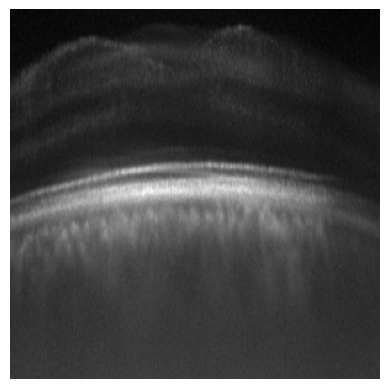

In [186]:
datasetpath = f'C:\Datasets\OCTData\ICIP training data\\0\{patient}'

print(datasetpath)
print(os.path.exists(datasetpath))

def extract_number(filename):
    match = re.search(r'\((\d+)\)', filename)
    return int(match.group(1)) if match else -1

images = sorted(
    [os.path.join(datasetpath, image) for image in os.listdir(datasetpath)],
    key=lambda x: extract_number(os.path.basename(x))
)

loaded_images = [Image.open(image) for image in images]


image_arrays = [np.array(image) for image in loaded_images]
stacked_images = np.stack(image_arrays, axis=0)
fused_image_array = np.mean(stacked_images, axis=0).astype(np.uint8)
fused_image = Image.fromarray(fused_image_array)


plt.imshow(fused_image_array, cmap='gray')
plt.axis('off')

## Mask

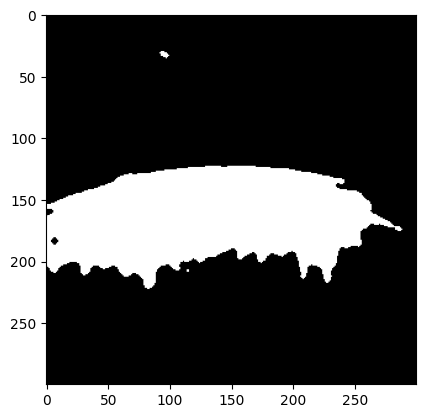

In [187]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2

def create_oct_mask(image, threshold_factor=0.3):
    """
    Create a binary mask for OCT image focusing on tissue regions
    
    Args:
        image: Input tensor or numpy array [H, W] or [1, H, W]
        threshold_factor: Factor to adjust sensitivity of tissue detection
    """
    # Convert to numpy if tensor
    if torch.is_tensor(image):
        image = image.cpu().detach().numpy()
    
    # Ensure 2D
    if image.ndim == 3:
        image = image.squeeze()
    
    # Normalize to 0-1
    image = (image - image.min()) / (image.max() - image.min())
    
    # Calculate adaptive threshold
    mean_val = np.mean(image)
    std_val = np.std(image)
    threshold = mean_val + threshold_factor * std_val
    
    # Create initial mask
    mask = (image > threshold).astype(np.float32)
    
    # Clean up mask
    kernel = np.ones((3,3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    # Remove small objects and fill holes
    mask = cv2.medianBlur(mask.astype(np.uint8), 5)
    
    return mask

def normalize_with_mask(x, mask):
    """
    Normalize image using the mask region statistics
    """
    # Apply mask to get tissue region values
    tissue_values = x[mask > 0]
    
    if len(tissue_values) > 0:
        tissue_min = torch.min(tissue_values)
        tissue_max = torch.max(tissue_values)
        
        # Normalize based on tissue values
        x_normalized = (x - tissue_min) / (tissue_max - tissue_min + 1e-6)
    else:
        x_normalized = (x - x.min()) / (x.max() - x.min() + 1e-6)
    
    return x_normalized

# Modified normalize_output function for your network
def normalize_output(self, x, target_min=None, target_max=None):
    """
    Normalize using tissue mask
    """
    if target_min is None or target_max is None:
        return x
        
    batch_size = x.size(0)
    normalized = []
    
    for b in range(batch_size):
        img = x[b].squeeze()
        
        # Create mask
        mask = create_oct_mask(img)
        mask = torch.from_tensor(mask).to(img.device)
        
        # Normalize using mask
        img_normalized = normalize_with_mask(img, mask)
        img_scaled = img_normalized * (target_max - target_min) + target_min
        
        normalized.append(img_scaled.unsqueeze(0))
    
    return torch.stack(normalized)

# visualise
reference_mask = create_oct_mask(fused_image_array, threshold_factor=0.3)
plt.imshow(reference_mask, cmap='gray')

## Get only the good images

In [188]:
def compute_dice_coefficient(mask1, mask2):
    intersection = np.sum(mask1 * mask2)
    sum_masks = np.sum(mask1) + np.sum(mask2)
    if sum_masks == 0:
        return 1.0  # Both masks are empty
    dice = (2. * intersection) / sum_masks
    return dice

def compute_jaccard_index(mask1, mask2):
    intersection = np.sum(mask1 * mask2)
    union = np.sum(mask1) + np.sum(mask2) - intersection
    if union == 0:
        return 1.0  # Both masks are empty
    jaccard = intersection / union
    return jaccard


In [189]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm

def process_folder(input_folder):

    masks = {}

    image_files = [f for f in os.listdir(input_folder) if f.endswith(('.png', '.jpg', '.tiff'))]
    
    for filename in tqdm(image_files, desc="Processing images"):

        image_path = os.path.join(input_folder, filename)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        
        mask = create_oct_mask(image)

        masks[filename] = mask
        

    return masks

input_folder = datasetpath

# Process all images
masks = process_folder(input_folder)

Processing images: 100%|██████████| 273/273 [00:00<00:00, 1105.27it/s]


In [190]:
masks

{'RawDataQA10 (1).tiff': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'RawDataQA10 (10).tiff': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 1, 1],
        [0, 0, 0, ..., 1, 1, 1]], dtype=uint8),
 'RawDataQA10 (100).tiff': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'RawDataQA10 (101).tiff': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uin

In [191]:
# Lists to store scores and image paths
dice_scores = []
jaccard_scores = []
image_paths = []

# Iterate through the masks dictionary
for mask_name, mask in masks.items():
    # Ensure mask is binary (skip thresholding, as masks are already binary)
    mask = (mask > 0).astype(np.uint8)  # Convert to binary mask (if not already)

    # Resize the reference mask if necessary
    if reference_mask.shape != mask.shape:
        resized_reference_mask = cv2.resize(reference_mask, (mask.shape[1], mask.shape[0]), interpolation=cv2.INTER_NEAREST)
    else:
        resized_reference_mask = reference_mask

    # Ensure reference mask is binary
    resized_reference_mask = (resized_reference_mask > 0).astype(np.uint8)

    # Compute similarity metrics
    dice = compute_dice_coefficient(mask, resized_reference_mask)
    jaccard = compute_jaccard_index(mask, resized_reference_mask)

    # Store the scores and corresponding image name
    dice_scores.append(dice)
    jaccard_scores.append(jaccard)
    image_paths.append(mask_name)

    # Optional: Print the scores for each mask
    print(f"Mask: {mask_name}, Dice Coefficient: {dice:.4f}, Jaccard Index: {jaccard:.4f}")


Mask: RawDataQA10 (1).tiff, Dice Coefficient: 0.3647, Jaccard Index: 0.2230
Mask: RawDataQA10 (10).tiff, Dice Coefficient: 0.4097, Jaccard Index: 0.2576
Mask: RawDataQA10 (100).tiff, Dice Coefficient: 0.5977, Jaccard Index: 0.4263
Mask: RawDataQA10 (101).tiff, Dice Coefficient: 0.6228, Jaccard Index: 0.4523
Mask: RawDataQA10 (102).tiff, Dice Coefficient: 0.6440, Jaccard Index: 0.4749
Mask: RawDataQA10 (103).tiff, Dice Coefficient: 0.6531, Jaccard Index: 0.4849
Mask: RawDataQA10 (104).tiff, Dice Coefficient: 0.6508, Jaccard Index: 0.4824
Mask: RawDataQA10 (105).tiff, Dice Coefficient: 0.6692, Jaccard Index: 0.5028
Mask: RawDataQA10 (106).tiff, Dice Coefficient: 0.6883, Jaccard Index: 0.5247
Mask: RawDataQA10 (107).tiff, Dice Coefficient: 0.6633, Jaccard Index: 0.4963
Mask: RawDataQA10 (108).tiff, Dice Coefficient: 0.6719, Jaccard Index: 0.5059
Mask: RawDataQA10 (109).tiff, Dice Coefficient: 0.6768, Jaccard Index: 0.5115
Mask: RawDataQA10 (11).tiff, Dice Coefficient: 0.3818, Jaccard Inde

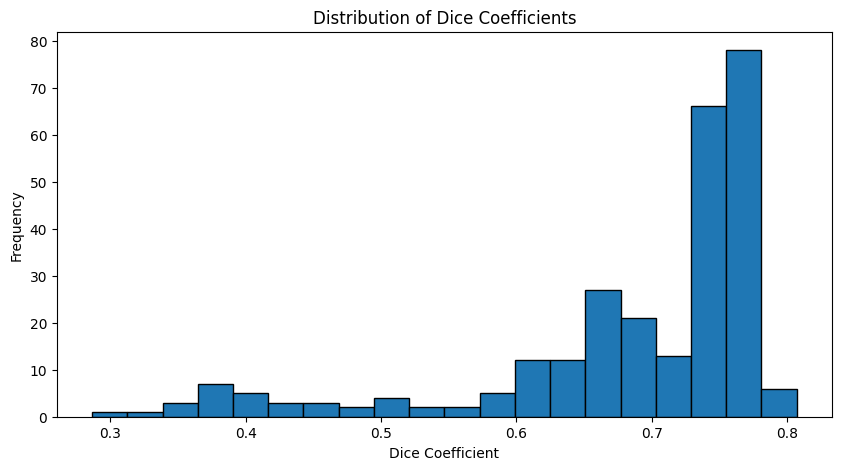

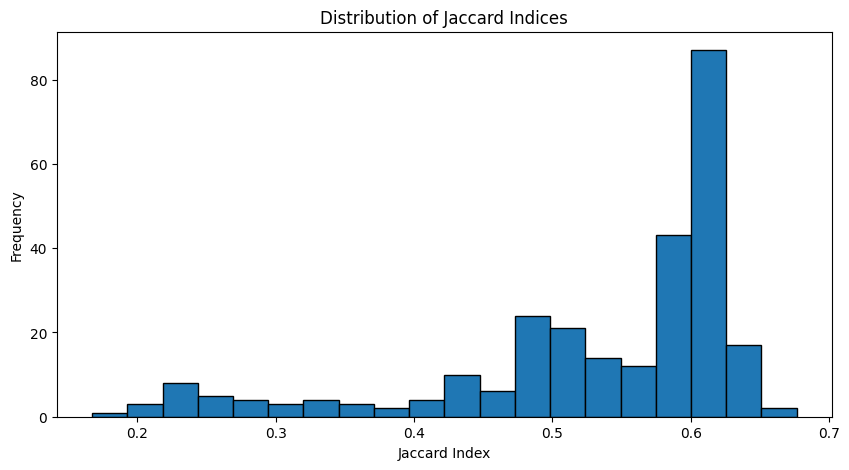

In [192]:
# Plot histogram of Dice coefficients
plt.figure(figsize=(10, 5))
plt.hist(dice_scores, bins=20, edgecolor='black')
plt.title('Distribution of Dice Coefficients')
plt.xlabel('Dice Coefficient')
plt.ylabel('Frequency')
plt.show()

# Plot histogram of Jaccard indices
plt.figure(figsize=(10, 5))
plt.hist(jaccard_scores, bins=20, edgecolor='black')
plt.title('Distribution of Jaccard Indices')
plt.xlabel('Jaccard Index')
plt.ylabel('Frequency')
plt.show()


In [193]:
# Set thresholds
dice_threshold = 0.5  # Adjust based on histograms
jaccard_threshold = 0.4  # Adjust based on histograms

good_images = []
bad_images = []

for i, dice in enumerate(dice_scores):
    if dice >= dice_threshold:
        good_images.append(image_paths[i])
    else:
        bad_images.append(image_paths[i])


In [194]:
len(good_images), len(bad_images)

(248, 25)

In [195]:
#np_good_images = {}
np_good_images = []
for img in good_images:
    npimg = cv2.imread(os.path.join(input_folder, img))
    #np_good_images[img] = npimg
    np_good_images.append(npimg)

len(np_good_images)

248

## Recompute the fusion

In [196]:
def save_fused_images(fused_images, level):

    output_dir = f'../FusedDataset/{patient}/FusedImages_Level_{level}'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir, exist_ok=True)
    for idx, image_array in enumerate(fused_images):
        image = Image.fromarray(image_array.astype(np.uint8)).convert('L')
        # save as grayscale



        image_filename = f'Fused_Image_Level_{level}_{idx}.tif'
        image.save(os.path.join(output_dir, image_filename))

    print(f"Saved {len(fused_images)} fused images at Level {level} in {output_dir}")

def fuse_images(image_list, level=0):
    """
    Recursively fuse images to create fusion levels.
    """
    if len(image_list) == 1:

        return
    else:
        fused_images = []
        # Pair images and compute their average
        for i in range(0, len(image_list), 2):
            if i + 1 < len(image_list):
                fused = np.mean([image_list[i], image_list[i + 1]], axis=0)
            else:
                fused = image_list[i]
            fused_images.append(fused)
        # Save fused images at the current level
        save_fused_images(fused_images, level)
        # Recursively fuse the next level
        fuse_images(fused_images, level + 1)

# Start the fusion process
fuse_images(np_good_images)

Saved 124 fused images at Level 0 in ../FusedDataset/RawDataQA (10)/FusedImages_Level_0
Saved 62 fused images at Level 1 in ../FusedDataset/RawDataQA (10)/FusedImages_Level_1
Saved 31 fused images at Level 2 in ../FusedDataset/RawDataQA (10)/FusedImages_Level_2
Saved 16 fused images at Level 3 in ../FusedDataset/RawDataQA (10)/FusedImages_Level_3
Saved 8 fused images at Level 4 in ../FusedDataset/RawDataQA (10)/FusedImages_Level_4
Saved 4 fused images at Level 5 in ../FusedDataset/RawDataQA (10)/FusedImages_Level_5
Saved 2 fused images at Level 6 in ../FusedDataset/RawDataQA (10)/FusedImages_Level_6
Saved 1 fused images at Level 7 in ../FusedDataset/RawDataQA (10)/FusedImages_Level_7
